In [68]:
import mne
import os
from config import *
import numpy as np
import pickle as pkl

path_fwd = os.path.join("D:/data/flex_ssm", forward_models[0]["path_fwd"])
path_info = os.path.join("D:/data/flex_ssm",forward_models[0]["path_info"])

fwd = mne.read_forward_solution(path_fwd, verbose=0)
fwd = mne.convert_forward_solution(fwd, force_fixed=True)
fwd["sol"]["data"] /= np.linalg.norm(fwd["sol"]["data"], axis=0)

fn = path_info
with open(fn, 'rb') as f:
    info = pkl.load(f)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


0 files missing from root.txt in C:\Users\lukas\mne_data\MNE-sample-data\subjects
0 files missing from bem.txt in C:\Users\lukas\mne_data\MNE-sample-data\subjects\fsaverage
Opening raw data file C:\Users\lukas\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>


Text(0.5, 1.0, '0.37')

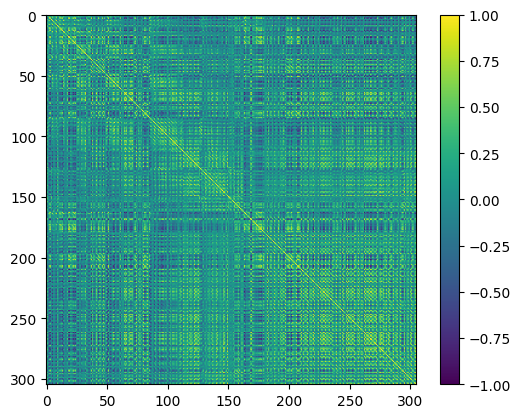

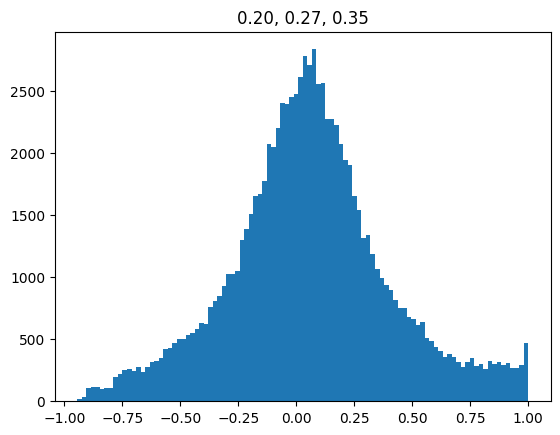

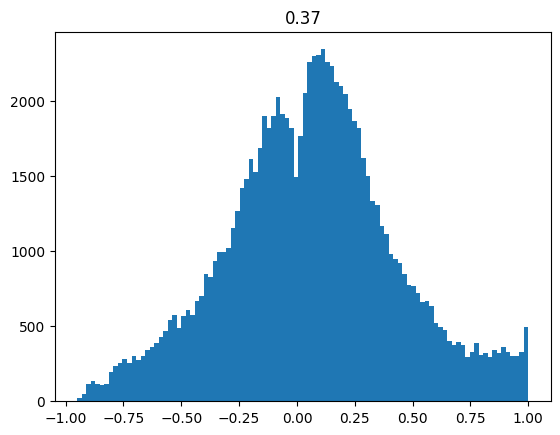

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
mne.datasets.fetch_fsaverage(verbose=True)
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
events = mne.find_events(raw, stim_channel="STI 014")
raw = raw.pick_types(meg=True, eeg=False, eog=False, stim=False)
first_event_onset = events[0, 0]
data = raw.get_data()[:, :first_event_onset]

noise_cov = data @ data.T
diag = np.sqrt(np.diag(noise_cov))
corr_matrix = noise_cov / np.outer(diag, diag)

plt.figure()
plt.imshow(corr_matrix, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.hist(corr_matrix.flatten(), bins=100)
med = np.median(abs(corr_matrix))
mean = np.mean(abs(corr_matrix))
std = np.std(corr_matrix)
plt.title(f"{med:.2f}, {mean:.2f}, {std:.2f}")

0.25 -0.76 0.25 -0.9 1.0
0.35 0 0.35 -0.94 1.0
0.5 0.48 0.5 -0.97 1.0
0.75 0.83 0.75 -0.99 1.0
0.9 0.95 0.91 -1.0 1.0


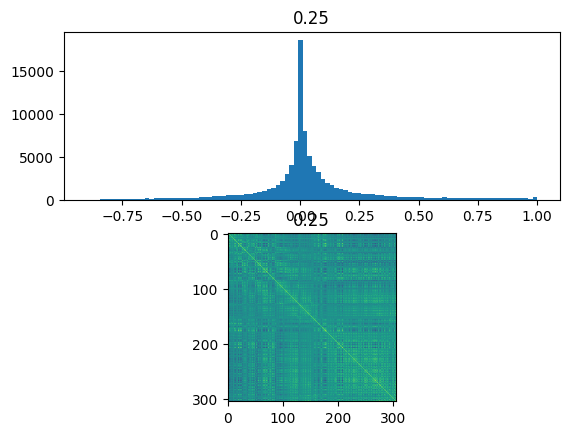

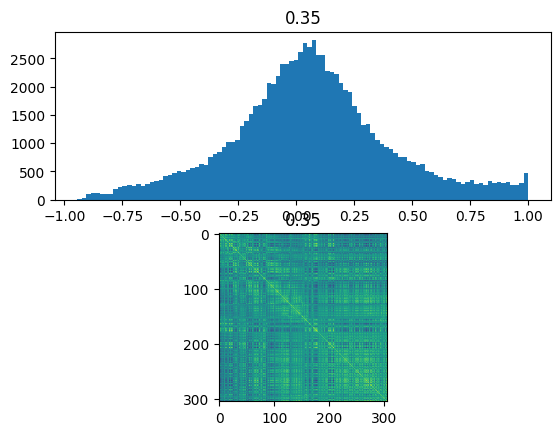

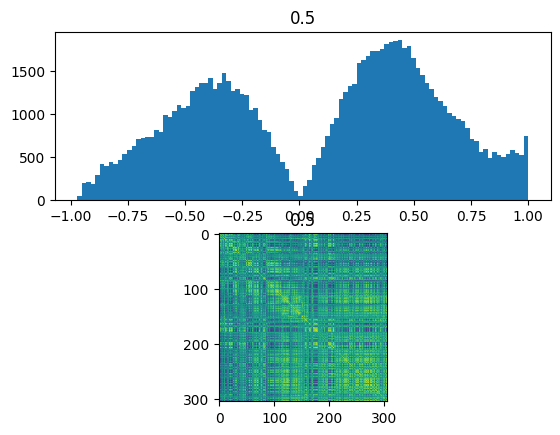

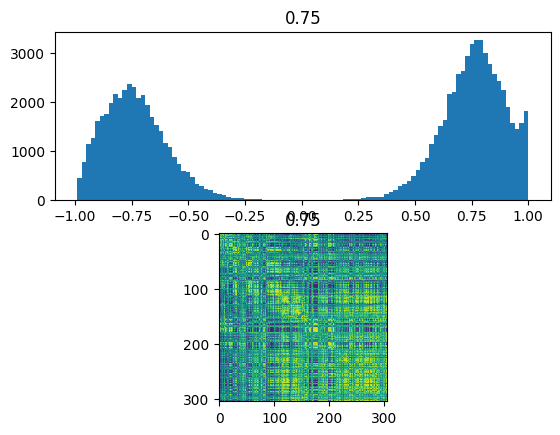

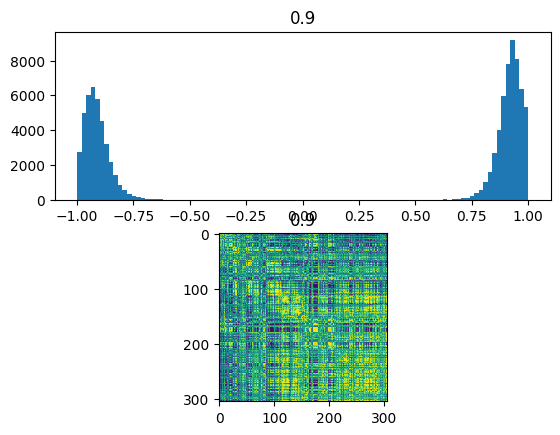

In [3]:
def broaden(X, mag):
    
    w = np.sign(X) * (abs(X)**(1-mag))
    return w

val_range = [-0.76, 0, 0.48, 0.83, 0.95]
target_std = [0.25, 0.35, 0.5, 0.75, 0.9]
covariances = dict()
for val, target in zip(val_range, target_std):
    new_X = broaden(corr_matrix.flatten(), val).reshape(*corr_matrix.shape)
    covariances[str(target)] = new_X
    print(target, val, round(new_X.std(), 2), round(new_X.min(), 2), round(new_X.max(), 2))

    plt.figure()
    plt.subplot(211)
    plt.hist(new_X.flatten(), bins=100)
    plt.title(f"{target}")

    plt.subplot(212)
    plt.imshow(new_X, vmin=-1, vmax=1)
    plt.title(target)


0.1 0.28822779178974867 0.11 -0.27 1.0
0.25 0.7205694794743716 0.25 -0.68 1.0
0.35 1.0087972712641202 0.35 -0.95 1.0
0.5 1.441138958948743 0.47 -1.0 1.0
0.75 2.1617084384231147 0.59 -1.0 1.0
0.9 2.5940501261077378 0.64 -1.0 1.0
1.1 3.170505709687235 0.7 -1.0 1.0
1.25 3.6028473973718578 0.73 -1.0 1.0
1.35 3.8910751891616067 0.74 -1.0 1.0
1.5 4.323416876846229 0.77 -1.0 1.0
1.75 5.043986356320601 0.8 -1.0 1.0
1.9 5.476328044005224 0.81 -1.0 1.0


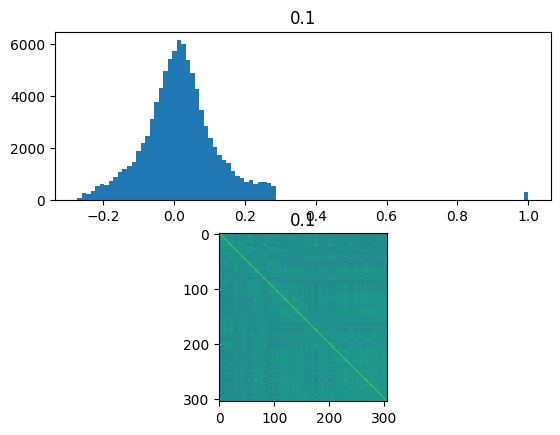

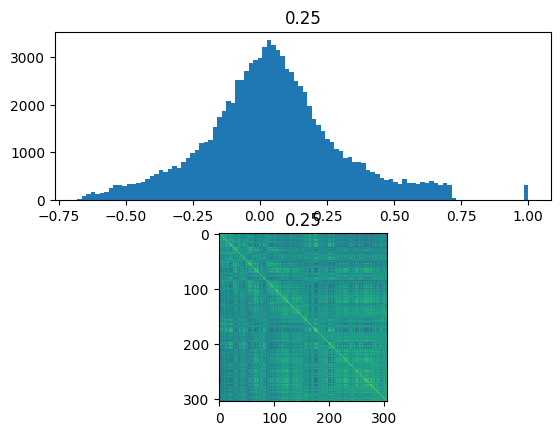

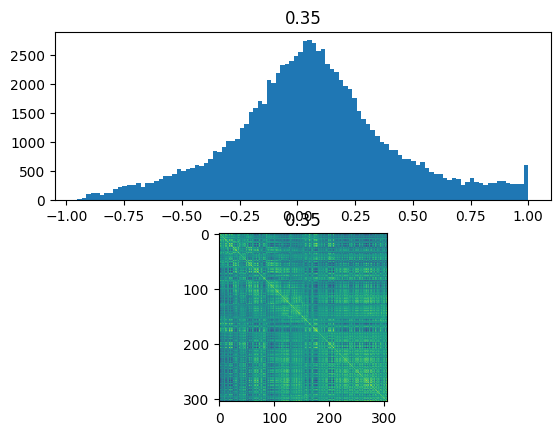

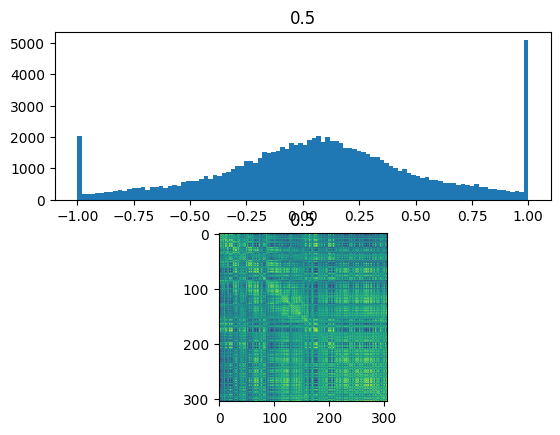

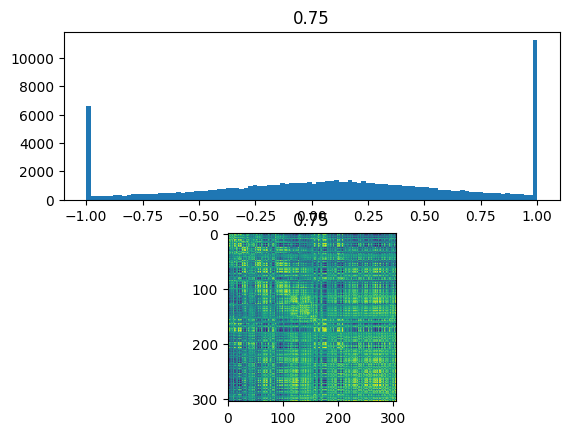

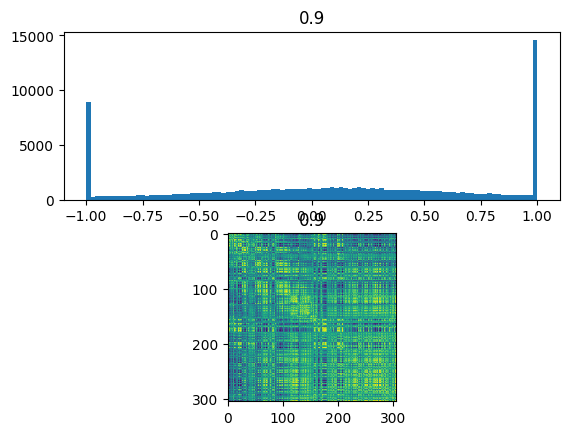

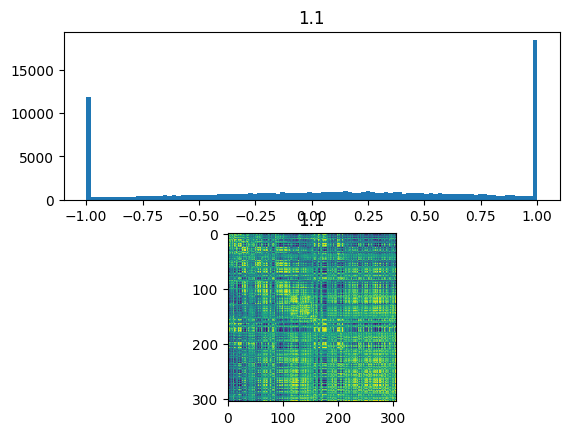

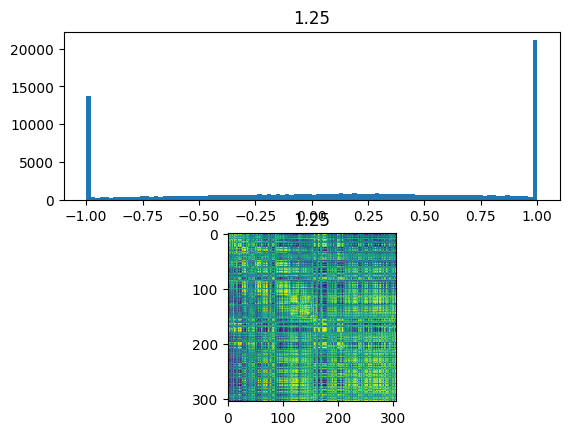

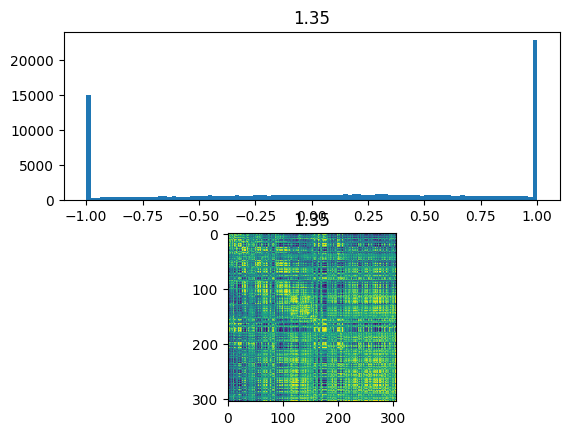

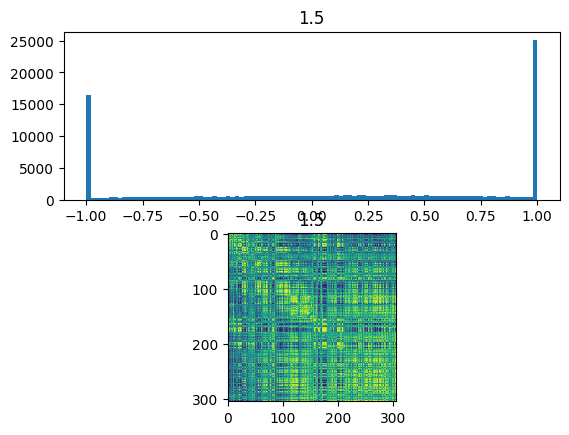

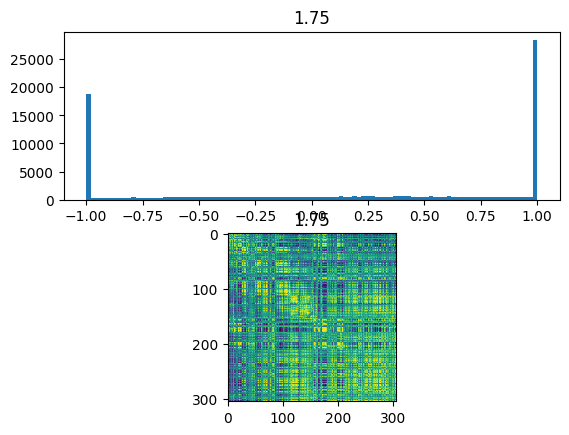

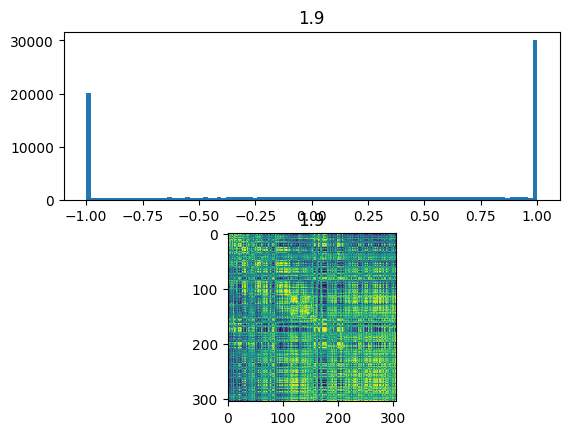

In [30]:
def broaden(X, mag):
    
    w = np.sign(X) * (abs(X)**(1-mag))
    return w
actual_std = corr_matrix.std()
# val_range = [-0.76, 0, 0.48, 0.83, 0.95]
target_std = [0.1, 0.25, 0.35, 0.5, 0.75, 0.9,]
target_std = target_std + [1+i for i in target_std]
covariances = dict()
for target in target_std:
    # new_X = broaden(corr_matrix.flatten(), val).reshape(*corr_matrix.shape)
    new_X = np.clip(corr_matrix * (target / actual_std), a_min=-1, a_max=1)
    np.fill_diagonal(new_X, 1)
    covariances[str(target)] = new_X

    print(target, target/actual_std, round(new_X.std(), 2), round(new_X.min(), 2), round(new_X.max(), 2))

    plt.figure()
    plt.subplot(211)
    plt.hist(new_X.flatten(), bins=100)
    plt.title(f"{target}")

    plt.subplot(212)
    plt.imshow(new_X, vmin=-1, vmax=1)
    plt.title(target)


noise covs range from  0.46  -  0.7
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


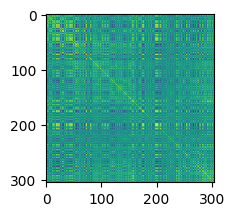

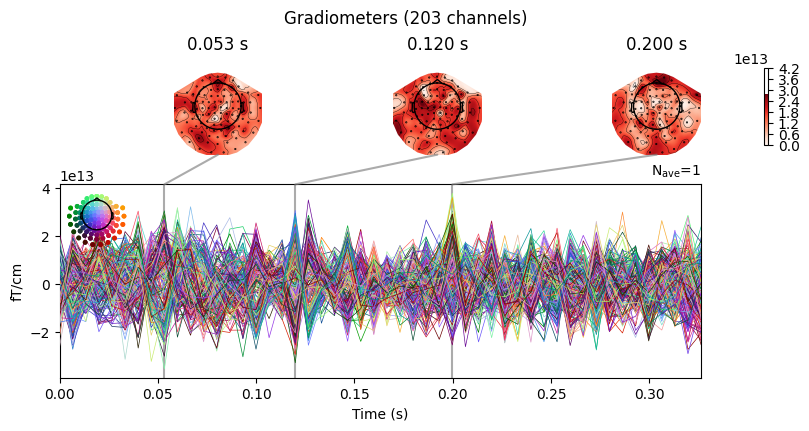

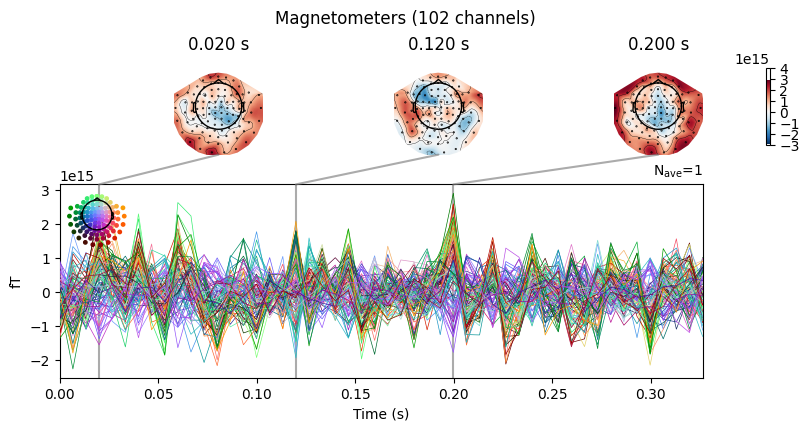

Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


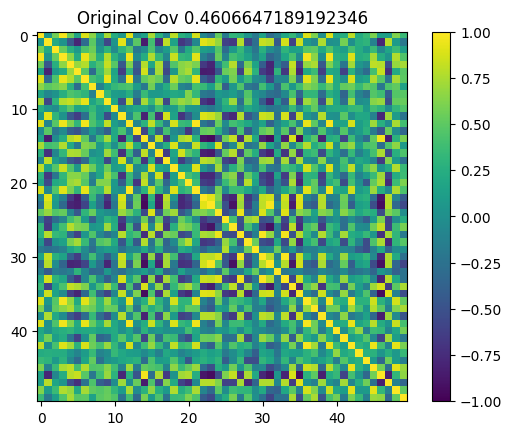

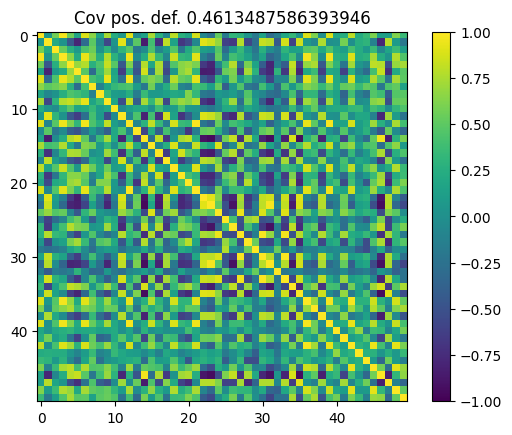

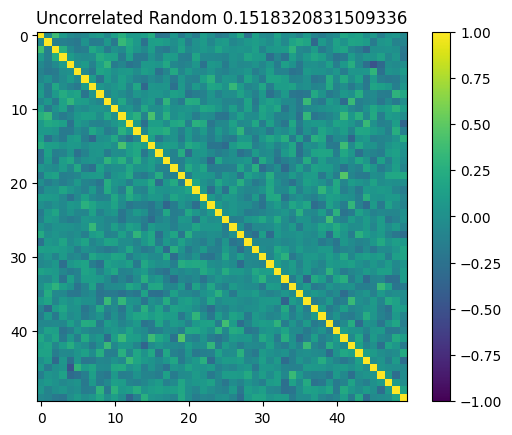

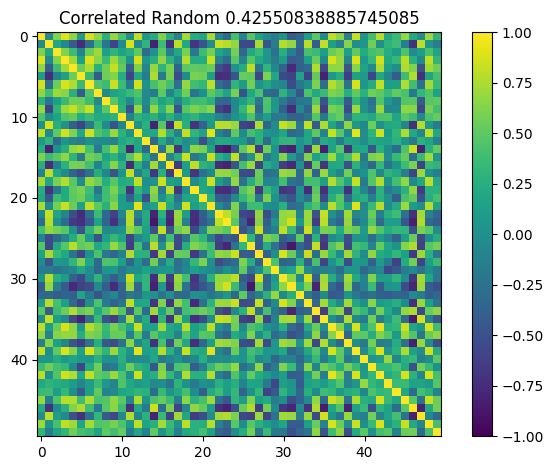

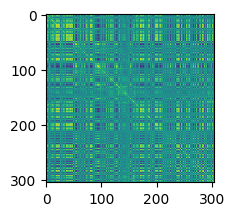

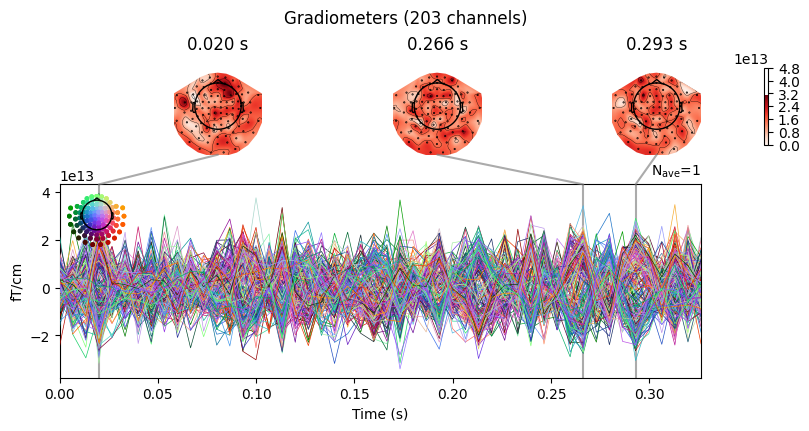

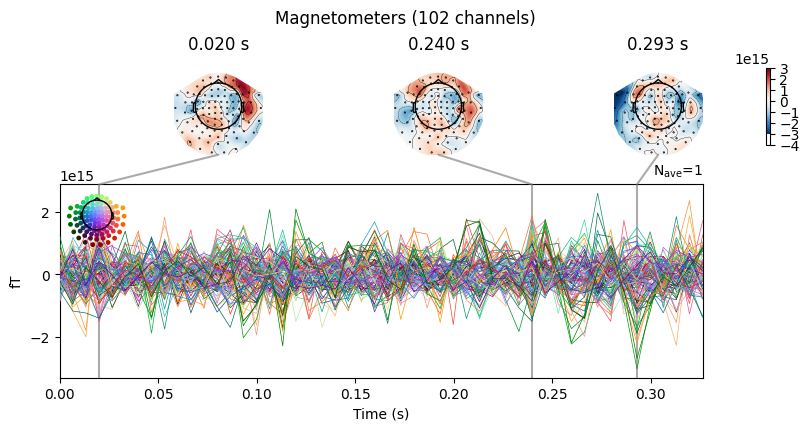

Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


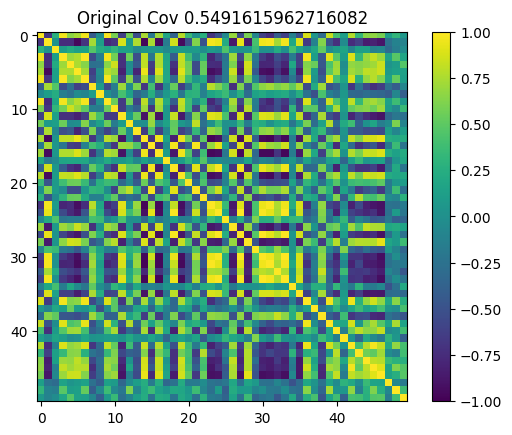

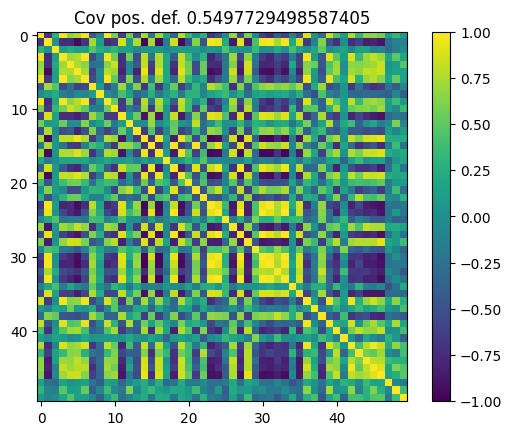

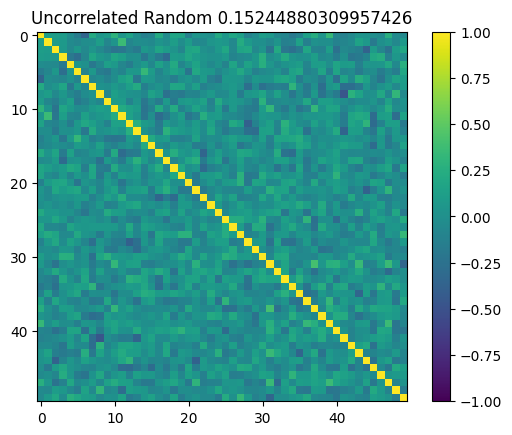

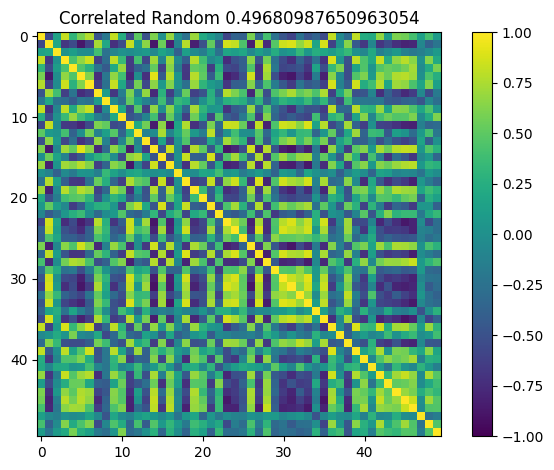

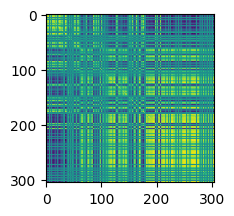

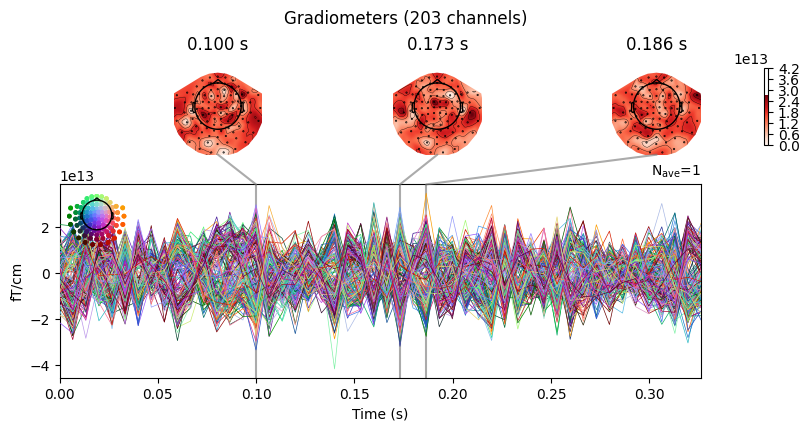

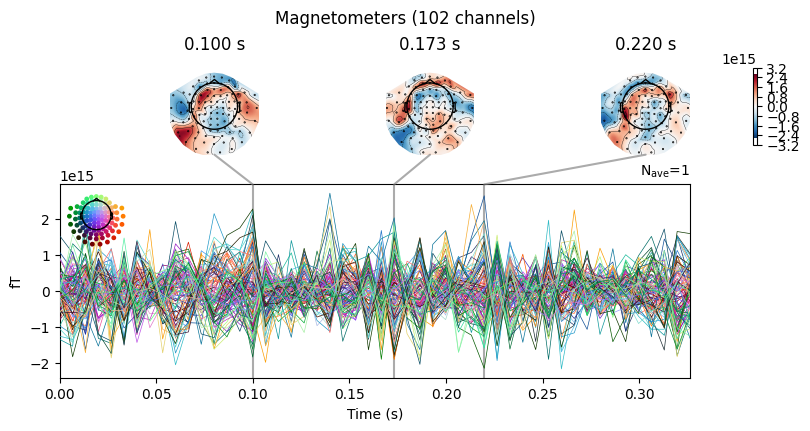

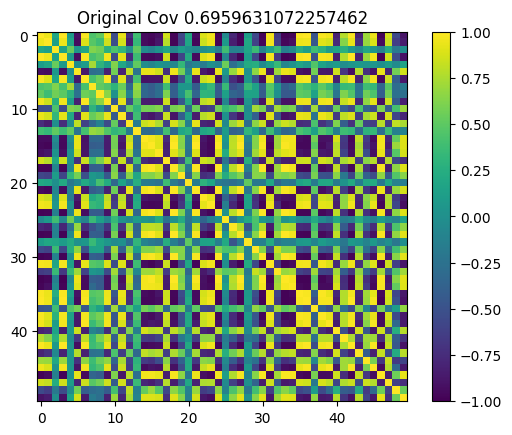

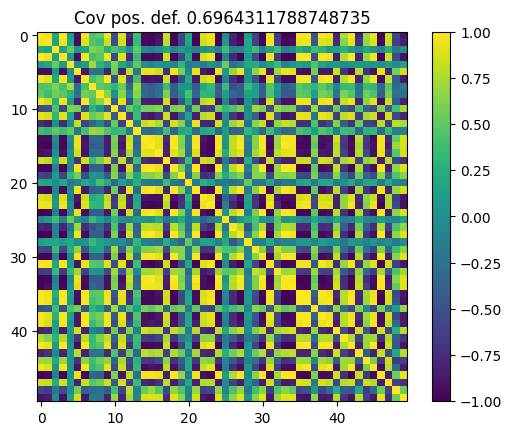

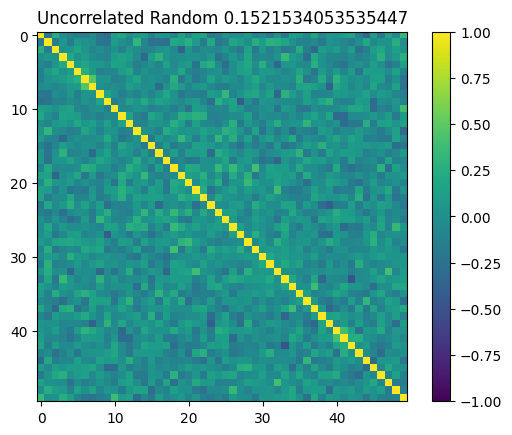

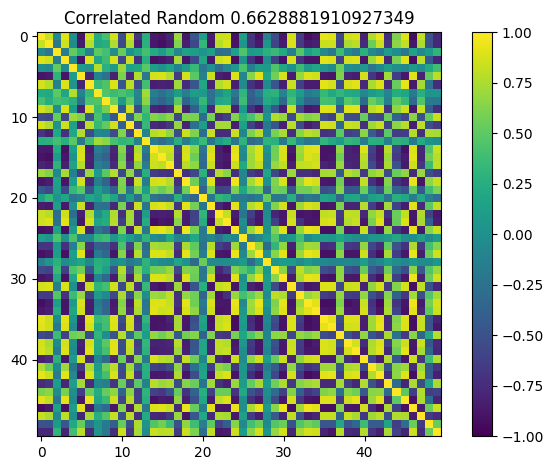

In [71]:
import numpy as np
import mne
import matplotlib.pyplot as plt
mne.datasets.fetch_fsaverage(verbose=True)
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
events = mne.find_events(raw, stim_channel="STI 014")
raw = raw.pick_types(meg=True, eeg=False, eog=False, stim=False)
first_event_onset = events[0, 0]
data = raw.get_data()[:, :first_event_onset]

T_range = (50, )
n_chans, n_total = data.shape
noise_corrs = []
sds = []
for T in T_range:
    for i in range(0, n_total-T, T):
        segment = data[:, i:i+T]
        noise_cov = segment @ segment.T
        diag = np.sqrt(np.diag(noise_cov))
        corr_matrix = noise_cov / np.outer(diag, diag)
        sd = corr_matrix.std()
        sds.append(sd)

        noise_corrs.append(corr_matrix)

    
# print(np.mean(sds), np.median(sds), np.min(sds), np.max(sds))
print("noise covs range from ", round(np.min(sds), 2), " - ",  round(np.max(sds), 2))

idx_medium = np.where(sds == np.median(sds))[0][0]
idx_low = np.where(sds == np.min(sds))[0][0]
idx_high = np.where(sds == np.max(sds))[0][0]

noise_covs = dict(low=noise_corrs[idx_low], medium=noise_corrs[idx_medium], high=noise_corrs[idx_high])

'''
for idx in [idx_low, idx_medium, idx_high]:


    plt.figure()
    plt.subplot(211)
    plt.imshow(noise_corrs[idx], vmin=-1, vmax=1)

    cov = noise_corrs[idx]
    # cov_ = make_positive_definite(cov, epsilon=1e-1)
    cov_ = regularize_matrix(cov, lambda_value=1e-1)

    X = np.random.randn(cov.shape[0], 50)

    cov_X = X @ X.T
    diag = np.sqrt(np.diag(cov_X))
    corr_X_before = cov_X / np.outer(diag, diag)

    X_corr = np.linalg.cholesky(cov_) @ X
    cov_X = X_corr @ X_corr.T
    diag = np.sqrt(np.diag(cov_X))
    corr_X_after = cov_X / np.outer(diag, diag)
    evoked = mne.EvokedArray(X_corr, info)
    evoked.plot_joint()
    plt.figure()
    plt.imshow(cov[50:100, 50:100], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"Original Cov {np.std(cov)}")

    plt.figure()
    plt.imshow(cov_[50:100, 50:100], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"Cov pos. def. {np.std(cov_)}")

    plt.figure()
    plt.imshow(corr_X_before[50:100, 50:100], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"Uncorrelated Random {np.std(corr_X_before)}")

    plt.figure()
    plt.imshow(corr_X_after[50:100, 50:100], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"Correlated Random {np.std(corr_X_after)}")

    plt.tight_layout()
'''